PPGCC - Programa de Pós-Graduação em Ciência da Computação 

Disciplina de Aprendizado de Máquina em Grafos

Atividade 2 - 1000 pts

Matheus Santos Araújo

# Importações

In [1]:
import os
import os.path as osp
import pickle
import logging

import torch
from torch_geometric import utils
from torch_geometric.data import Data

from ogb.graphproppred import PygGraphPropPredDataset
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from torch_geometric.data import DataLoader
from ogb.graphproppred import Evaluator

import networkx as nx
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import inv

# Dataset

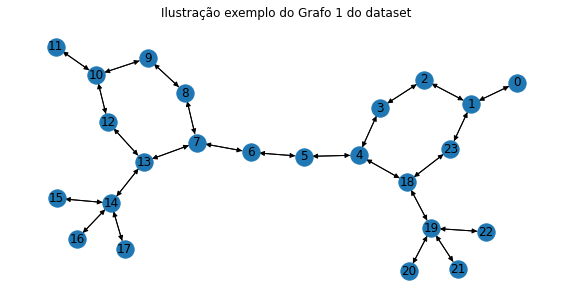

In [2]:
# Carregamento do dataset
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')

split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=1, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=1, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=1, shuffle=False)

# Train ----
graphs = []
for i in range (len(train_loader)):
    # Adiciona grafo networkx 
    graphs.append(utils.to_networkx(train_loader.dataset[i]))
        
ytrain = []
for graph in train_loader:
    ytrain.append(graph.y)
ytrain = np.array(ytrain)    
# ---

# Valid ---
graphsv= []
for i in range (len(valid_loader)):
    # Adiciona grafo networkx 
    graphsv.append(utils.to_networkx(valid_loader.dataset[i]))
        
yvalid = []
for graphv in valid_loader:
    yvalid.append(graphv.y)
yvalid = np.array(yvalid)    
# ---

# Test ----
graphstest = []
for i in range (len(test_loader)):
    # Adiciona grafo networkx 
    graphstest.append(utils.to_networkx(test_loader.dataset[i]))
        
ytest = []
for graphtest in test_loader:
    ytest.append(graphtest.y)
ytest = np.array(ytest)    
# ---

# Exemplo ilustrativo (primeiro grafo do dataset)
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_title('Ilustração exemplo do Grafo 1 do dataset')
nx.draw_kamada_kawai(graphs[0], with_labels=True, ax=ax)

# Passeio Aleatório
1 ) Implemente um algoritmo R para gerar o conjunto de vértices que são
percorridos em um passeio aleatório a partir de um vértice de origem u. O seu
algoritmo deve gerar um conjunto de r passeios aleatórios enviesados a partir
da origem u, com as probabilidades de transição definidas através dos
parâmetros p e q vistos em sala. Você deve escolher os valores de r, p e q.

In [3]:
# Função p/ o passeio aleatório
def passeioaleatorio(G, no, tamanhopasseio, p, q):
    passeio = [no]
    nosnateriores = None
    nosnateriores_vizinhos = []
    for _ in range(tamanhopasseio-1):
        noatual = passeio[-1]  
        noatual_vizinhos = np.array(list(G.neighbors(noatual)))  
        probabilidade = np.array([1/q] * len(noatual_vizinhos), dtype=float) 
        probabilidade[noatual_vizinhos==nosnateriores] = 1/p 
        probabilidade[(np.isin(noatual_vizinhos, nosnateriores_vizinhos))] = 1 
        norm_probabilidade = probabilidade/sum(probabilidade) 
        if len(noatual_vizinhos) > 0:
            selecionado = np.random.choice(noatual_vizinhos, 1, p=norm_probabilidade)[0]  
        else:
            selecionado = no
        passeio.append(selecionado)  
        nosnateriores_vizinhos = noatual_vizinhos
        nosnateriores = noatual
    
    return passeio

# Parâmetros do passeio
p = 0.15
q = 7
s = 15

# Geração passeio aleatorio para todos os nós de todos os grafos de treino
passeio = []
for i in range (len(graphs)):
    passeionos = []
    for node in graphs[i]:
        passeionos.append(passeioaleatorio(graphs[i], node, s, p, q))
    passeio.append(passeionos)
    
# Geração passeio aleatorio para todos os nós de todos os grafos de validação
passeiov = []
for i in range (len(graphsv)):
    passeionosv = []
    for node in graphsv[i]:
        passeionosv.append(passeioaleatorio(graphsv[i], node, s, p, q))
    passeiov.append(passeionosv)
    
# Geração passeio aleatorio para todos os nós de todos os grafos de teste
passeiotest = []
for i in range (len(graphstest)):
    passeionostest = []
    for node in graphstest[i]:
        passeionostest.append(passeioaleatorio(graphstest[i], node, s, p, q))
    passeiotest.append(passeionostest)    

# Node2vec

2 ) Implemente o algoritmo node2vec para projetar os vértices , utilizando o
método do gradiente (em sua versão normal ou estocástica) para otimizar a
projeção dos vértices. Você pode usar implementações existentes do
gradiente.

In [4]:
# Executa a otimização do node2vec dados os passeios aleatórios nos grafos de treino
node_vec = []
for i in range (len(graphs)):
    node_vec.append(Word2Vec(passeio[i], hs=1, sg = 1, window=10, vector_size = 64, min_count=1, workers=8, seed=42))

# Verifica possiveis erros    
for i in range (len(graphs)):    
    if node_vec[i] is None:
        print("modelo não treinado")
        
# Executa a otimização do node2vec dados os passeios aleatórios nos grafos de validação
node_vecv = []
for i in range (len(graphsv)):
    node_vecv.append(Word2Vec(passeiov[i], hs=1, sg = 1, window=10, vector_size = 64, min_count=1, workers=8, seed=42))

# Verifica possiveis erros    
for i in range (len(graphsv)):    
    if node_vecv[i] is None:
        print("modelo não treinado")
        
# Executa a otimização do node2vec dados os passeios aleatórios nos grafos de teste
node_vectest = []
for i in range (len(graphstest)):
    node_vectest.append(Word2Vec(passeiotest[i], hs=1, sg = 1, window=10, vector_size = 64, min_count=1, workers=8, seed=42))

# Verifica possiveis erros    
for i in range (len(graphstest)):    
    if node_vectest[i] is None:
        print("modelo não treinado")        

# Projeção de Grafos

3 ) Implemente um algoritmo para gerar a projeção de um grafo. O seu algoritmo
deve usar a abordagem de adicionar um vértice adjacente a todos os vértices
do grafo, utilizando então o node2vez para determinar a projeção do vértice
adicionado, que será a projeção do grafo inteiro.

In [67]:
# Percorre todos os nós de cada grafo de treino e gera a projeção do grafo usando a média
X_node_vec = []
for i in range (len(graphs)):
    X_graph = []
    for j in range(len(graphs[i].nodes)):
        X_graph.append(node_vec[i].wv.__getitem__(j)) # node2vec [1 ... N]
    X_Graph2 = sum(X_graph) / len(X_graph) # média da incorporação dos nós [1 ... N]
    X_node_vec.append(X_Graph2) 
    
# Percorre todos os nós de cada grafo de validação e gera a projeção do grafo usando a média
X_node_vecv = []
for i in range (len(graphsv)):
    X_graphv = []
    for j in range(len(graphsv[i].nodes)):
        X_graphv.append(node_vecv[i].wv.__getitem__(j)) # node2vec [1 ... N]
    X_Graph2v = sum(X_graphv) / len(X_graphv) # média da incorporação dos nós [1 ... N]
    X_node_vecv.append(X_Graph2v) 
    
# Percorre todos os nós de cada grafo de teste e gera a projeção do grafo usando a média
X_node_vectest = []
for i in range (len(graphstest)):
    X_graphtest = []
    for j in range(len(graphstest[i].nodes)):
        X_graphtest.append(node_vectest[i].wv.__getitem__(j)) # node2vec [1 ... N]
    X_Graph2test = sum(X_graphtest) / len(X_graphtest) # média da incorporação dos nós [1 ... N]
    X_node_vectest.append(X_Graph2test) 

# Modelo

4 ) Utilize o algoritmo de classificação de sua escolha para operar no dataset
utilizando como entrada o vetor projeção do grafo, bem como outras features
que você considere importante derivar a partir do grafo (as features nos
vértices ou arestas).

## Treino 

In [65]:
tree = DecisionTreeClassifier()
tree.fit(X_node_vec, ytrain)
y_predtrain = tree.predict(X_node_vec)
y_predvalid = tree.predict(X_node_vecv)
y_predtest = tree.predict(X_node_vectest)

## Resultados Obtidos - ROCAUC

5 ) Apresente os resultados obtidos pelo seu modelo, utilizando para avaliação o ROC-AUC (se não sabe do que se trata, veja em https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772), e compare os seus resultados com os obtidos em https://paperswithcode.com/sota/graph-property-prediction-on-ogbg-

In [66]:
# train ---
ytrain = np.reshape(ytrain, (len(ytrain), 1))
y_predtrain = np.reshape(y_predtrain, (len(ytrain), 1))
# valid ---
yvalid = np.reshape(yvalid, (len(yvalid), 1))
y_predvalid = np.reshape(y_predvalid, (len(yvalid), 1))
# test ---
ytest = np.reshape(ytest, (len(ytest), 1))
y_predtest = np.reshape(y_predtest, (len(ytest), 1))

evaluator = Evaluator(name = "ogbg-molhiv")

input_dicttrain = {"y_true": ytrain, "y_pred": y_predtrain}
input_dictvalid = {"y_true": yvalid, "y_pred": y_predvalid}
input_dicttest = {"y_true": ytest, "y_pred": y_predtest}

result_dicttrain = evaluator.eval(input_dicttrain)
result_dictvalid = evaluator.eval(input_dictvalid)
result_dicttest = evaluator.eval(input_dicttest)

print("Resultado do Conjunto de Treino")
print(result_dicttrain)

print("Resultado do Conjunto de Validação")
print(result_dictvalid)   

print("Resultado do Conjunto de Teste")
print(result_dicttest)

print("Matriz de Confusão do Conjunto de Teste")
print(confusion_matrix(ytest, y_predtest))

Resultado do Conjunto de Treino
{'rocauc': 1.0}
Resultado do Conjunto de Validação
{'rocauc': 0.5461722883597884}
Resultado do Conjunto de Teste
{'rocauc': 0.5102618822302478}
Matriz de Confusão do Conjunto de Teste
[[3789  194]
 [ 121    9]]
